# CLASSIFICAÇÃO DE RESUMOS ACADÊMICOS POR DISCIPLINA UTILIZANDO PYTORCH 

# Parte 2 - Construção do Algoritmo


---

# Bibliotecas Necessárias

In [ ]:
%%capture
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

!pip install transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertTokenizer, BertForSequenceClassification

!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import seaborn as sns
import time
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device) #Todos os valore e vetores são carregados na gpu, caso ela esteja disponível

### Funções de preparação do Dataset
- Limpeza dos textos
- Remoção de urls, hífen, símbolos
- Remoção de Stop Words

In [ ]:
def get_data(nome_arquivo,shuffle):
    ds = pd.read_csv(nome_arquivo,encoding="utf-8")
    if shuffle:
        ds = ds.sample(frac=1)
    ds['texto'] = ds['texto'].apply(str)
    return ds

stop = set(stopwords.words("portuguese"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"",text)

def remove_punct(text):
    translator = str.maketrans("","",'!""#$%&\'()*+,./:;<=>?@[\\]^_`{|}~º')
    translator = str.maketrans("","",'!""#$%&\'()*+,./:;<=>?@[\\]^_`{|}~º')
    return text.translate(translator)

def remove_numbers(text):
    result = ''.join([i for i in text if not i.isdigit()])
    return result

def remove_hifen(text):
    translator = str.maketrans('-',' ')
    return text.translate(translator)

pattern = re.compile(r"https?//(\S+|www)\.\S+")
def pat(df_t):
    for t in df_t.texto:
        matches = pattern.findall(t)
        for match in  matches:
            print(t)
            print(match)
            print(pattern.sub(r"",t))        
        if len(matches)> 0:
            break

def make_test(df_t):
    df_t["texto"] = df_t.texto.map(remove_URL)
    df_t["texto"] = df_t.texto.map(remove_punct)
    df_t["texto"] = df_t.texto.map(remove_hifen)
    #df_t["texto"] = df_t.texto.map(remove_numbers)
    df_t["texto"] = df_t.texto.map(remove_stopwords)

def prepare(teste):
    teste = remove_URL(teste)
    teste = remove_punct(teste)
    teste = remove_hifen(teste)
    teste = remove_stopwords(teste)    
    return teste

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

#counter = counter_word(df.texto)  

def prepare(teste):
    teste = remove_URL(teste)
    #teste = remove_punct(teste)
    teste = remove_hifen(teste)
    teste = remove_stopwords(teste)    
    return teste

# Carregamento do Dataset
- Carregamento
- Embaralhamento
- Conversão texto para String 
- Limpeza e formatação do texto

### O Dataset utilizado pode ser encontrado em:
 - [train.csv](https://github.com/mateusns12/Modelos-de-Classificacao/blob/master/Modelo-Eletrica-Eletronica/train.csv)
 - [eval.csv](https://github.com/mateusns12/Modelos-de-Classificacao/blob/master/Modelo-Eletrica-Eletronica/eval.csv)

Serão comparadas duas disciplinas extremamente parecidas entre si, Elétrica e Eletrônica. O modelo será testado em condições onde o contexto é semelhante e poucas palavras definem a classe da sentença.

In [ ]:
train_csv = 'https://raw.githubusercontent.com/mateusns12/Modelos-de-Classificacao/master/Modelo-Eletrica-Eletronica/train.csv'
eval_csv = 'https://raw.githubusercontent.com/mateusns12/Modelos-de-Classificacao/master/Modelo-Eletrica-Eletronica/eval.csv'

## As discussões sobre o dataset foram realizadas na parte 1 do trabalho, na análise exploratória dos dados, que pode ser vista no link abaixo:

[Parte 1 - Análise Exploratória dos Dados](https://colab.research.google.com/drive/1OvT62-UZio9h5sHZG7mMxO3tOkyuB0aG?usp=sharing)

### Carregamento dos Datasets de Treinamento e Teste, embaralhamento e aplicação das funções de limpeza

In [ ]:
df = get_data(train_csv,1)
dt = get_data(eval_csv,0)

In [ ]:
pat(df)
make_test(df)
pat(dt)
make_test(dt)

In [ ]:
size = 0.8
train_size = int(df.shape[0]*size)
train_df = df[:train_size]
val_df = df[train_size:]

# Modelo BERT

BERT, ou Bidirection Encoder Representation for Transformers, é um modelo Transformer desenvolvido com Pytorch, utilizando diversas camadas de Embeddings.
### Embeddings
Embeddings são representações vetoriais de cada palavra, onde através de diversas dimensões, um a palavra é clasificada em uma escala de -1 a 1 de acordo com as features do corpus de treinamento.
Um exemplo famoso é do palavra "Rainha". Em uma escala de -1 a 1, onde -1 seria o gênero masculino, e 1 o gênero feminino. Nesta escala, seria atribuida a palavra "Rainha", um vetor, onde a posição relativa à gênero teria valor 0.95, pois está mais próxima do gênero feminino.

No modelo BERT, essas camadas conseguem gerar um vetores para features, probabilidades, e principalmente a posição da palavra na sentença. O encoding positional permite ao modelo o processamento paralelo da sentença, de forma sequencial ou reversa, aumentando muito o desempenho se comparado a redes neurais sequenciais como RNN e LSTMS.

## Fine Tunning

Neste trabalho será abordado o processo de Fine-Tunning do modelo BERTimbau, para se adequar a Tarefa de Classificação de Disciplinas com o dataset de textos de Elétrica e Eletrônica.

# Definido o Modelo e o Tokenizador BERT

O Modelo BERT utilizado é o BERTimbau, um modelo brasileiro, pré-treinado pela NeuralMind AI, em português.

O modelo está hospedado na HuggingFace Library, uma biblioteca de modelos transformers que contém diversas classes já pré configuradas para diferentes tarefas de NLP. 

Seguindo a documentação, será utilizada a classe AutoModelForSequenceClassification. Esta classe contém em seu layer final uma camada softmax, que retornará um valor próximo do label definido para cada disciplina, e a função de perda CrossEntropyLoss.

Utilizando esta classe, não é necessário construir o modelo manualmente.

In [ ]:
%%capture
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased').to(device)

### Tokenização do Dataset de Treinamento e Teste
Utilizando o método batch_encode_plus é feita a tokenização do das sentenças em pares, desta forma é possível utilizar o dataset com a superclasse Dataset, do Pytorch, necessária no treinamento.

In [ ]:
df_tok = tokenizer.batch_encode_plus(df['texto'].tolist(), max_length=150, truncation= True, padding="max_length", 
                                  add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'pt')

In [ ]:
dt_tok = tokenizer.batch_encode_plus(dt['texto'].tolist(), max_length=150, truncation= True, padding="max_length", 
                                  add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'pt')

In [ ]:
print(df_tok['input_ids'].shape,df_tok['attention_mask'].shape)

torch.Size([820, 150]) torch.Size([820, 150])


Os modelos de atenção necessitam de uma transformação na forma dos tensores para criar os embeddings. A função torch.stack() concatena dois ou mais tensores na dimensão requerida pelo modelo. Neste trabalho é utilizada a dimensão 0.

In [ ]:
X = torch.stack((df_tok['input_ids'],df_tok['attention_mask']),dim=0)

In [ ]:
X_test = torch.stack((dt_tok['input_ids'],dt_tok['attention_mask']),dim=0)

Os valores inteiros dos Labels do Dataset são convertidos para variaveis do tipo double 32 bits utilizando Numpy.

In [ ]:
y = torch.Tensor(df['valor'].to_numpy())

In [ ]:
y_test = torch.Tensor(dt['valor'].to_numpy())

In [ ]:
y_test

tensor([1., 1., 1., 1., 0., 0., 0., 0.])

## As Classes Dataset e Dataloader
Até aqui o conteúdo do dataset foi transformado para se adequar aos layers dp Pytorch. Agora são necessários métodos que permitam obter as informações do dataset durante o treinamento e validação.

Pytorch provê uma superclasse Dataset, a qual o dataset customizado deve herdar os métodos. Os métodos len e getitem permitem que o DataLoader consiga separar as sequências em batches, ou seja conjuntos, de dimensões iguais, realizando um novo embaralhamento.

O objeto gerado pelo DataLoader é utilizado no treinamento, através de um iterador, a cada passo retorna um batch, com suas features e labels, que são direcionadas para o modelo.

In [ ]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self,X,y):
        self.X = X
        self.X = self.X.to(device)

        self.y = y
        self.y = self.y.to(device)

        self.len = len(y)

    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        return self.X[:,idx],self.y[idx]

### Geração do dataset de treinamento
**X** é o objeto gerado através do torch.stack(), agrupando os "input_ids" e "attention_masks" das sequências.

**y** são os labels convertidos para tipo double.

In [ ]:
dataset = MyDataset(X,y)

### Geração do dataset de Teste

In [ ]:
t_dataset = MyDataset(X_test,y_test)

## Definição do tamanho do dataset de treinamento e validação. 
Serão utilizados 90% dos textos para treinamento, e 10% para validação.
O batch ou conjunto de sentenças é definido para 16.

In [ ]:
train_size = 0.9
val_size = 0.1
BATCH = 16

In [ ]:
n_train = int(np.round(dataset.len*train_size))
n_val = int(np.round(dataset.len*val_size))

In [ ]:
n_train,n_val

(738, 82)

### Separação do dataset em treinamento e validação

In [ ]:
train_slice, val_slice = torch.utils.data.random_split(dataset,[n_train,n_val])

## Criação dos Dataloaders de Treinamento, Validação e teste
Estes dataloaders serão utilizados na rotina de teste. 

O batch para teste é setado em 1 para se observar o acerto para cada sentença individualmente.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_slice,batch_size=BATCH,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_slice,batch_size=BATCH,shuffle=True)

In [ ]:
test_loader = torch.utils.data.DataLoader(t_dataset,batch_size=1,shuffle=False)

# Congelando os parâmetros do modelo BERT
O modelo BERT tem milhões de parâmetros, gradientes e pesos vindos do pré treinamento. Retreinar esses parâmetros é custoso, e para fins de fine tunning, não traz melhoras significativas pois o dataset é pequeno demais. 

Para desativar o treinamento destes parâmetros, a propriedade requires_grad é setada para False para todos eles.

In [ ]:
for param in model.base_model.parameters():
    param.requires_grad = False

# Definição de métricas e uso do Scheduler

Como a classe utilizada SequenceClassification já retorna um modelo pré treinado com ultima camada softmax, e funcão perda CrossEntropyLoss, não é possível alterar esses parâmetros, a menos que seja construído um modelo do zero.

Consultando a documentação, a taxa de aprendizagem deste modelo, que utiliza o otimizador AdamW é lr = 2e-5.

Com o scheduler, é possível adicionar uma variação da taxa de aprendizagem. Em modelos de atenção, é desejável reduzir a taxa de aprendizagem, para diminuir a função perda. Com o scheduler, a cada época, a taxa de aprendizagem é multiplicada pelo valor determinado. 

Neste exemplo, o scheduler é setado para 0.9992, ou seja, a cada iteração, a taxa de aprendizagem será apenas 99,92% da anterior, permitindo uma variação controlada.

Para comparação, nos resultados será apresentada uma comparação entre os treinamentos com e sem scheduler. 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

acc_calc = lambda output,labels : (labels == output.argmax(axis = 1)).sum()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim,0.9992)

#Definição das épocas e passos

Aqui são definidas as épocas. Modelo BERT necessita de poucas épocas para conseguir uma boa precisão. Frequentemente os resultados para precisão ficam entre 76% a 84%. Acima disso, o modelo provavelmente estará sofrendo de overfitting e memorizando o dataset.

Outra caracteristica do Modelo BERT é que a precisão de validação é maior que a recisão de treinamento

#### Passos e validação

Para este modelo, em cada época, ele realizará 200 passos de otimização, e validará por 20

In [ ]:
epocas = 40
steps = 200
validation = 20

In [ ]:
hist_train_acc = []
hist_train_loss = []
hist_val_acc = []
hist_val_loss = []

for i in range(epocas):
    n_train_ex = 0
    n_val_ex = 0

    train_hit = 0
    val_hit = 0

    train_bar = tqdm(total = steps, desc='Train',unit='steps',position = 0,leave=True)
    val_bar = tqdm(total = validation, desc='Val',unit='samples',position = 0,leave=True)

    for batch_num, (features,labels) in enumerate(train_loader):

        train_loss = 0

        model.train()

        input_ids,input_masks = features [:,0,:],features[:,1,:]

        var_temp = model(input_ids,input_masks,labels = labels.long())

        loss, logits = var_temp[0], var_temp[1]

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item()

        softmax_pred = nn.functional.softmax(logits,dim=1)
        train_hit +=  acc_calc(softmax_pred,labels)

        train_bar.update(1)

        n_train_ex += features.shape[0]

        scheduler.step()

        if (batch_num + 1) % steps == 0:
          train_bar.close()
          break

    for batch_num, (features,labels) in enumerate(val_loader):
        
        with torch.no_grad():
            val_loss = 0

            model.eval()

            input_ids,input_masks = features [:,0,:],features[:,1,:]

            var_temp2 = model(input_ids,input_masks,labels = labels.long())

            loss, logits = var_temp2[0], var_temp2[1]

            val_loss += loss.item()

            softmax_pred = nn.functional.softmax(logits,dim=1)
            val_hit +=  acc_calc(softmax_pred,labels)

            val_bar.update(1)

            n_val_ex +=features.shape[0]

            if (batch_num + 1) % validation == 0:
                val_bar.close()
                break
    train_acc = torch.true_divide(train_hit,n_train_ex)
    val_acc = torch.true_divide(val_hit,n_val_ex)

    print(f'\nSUMMARY - {i+1}\t Train loss: {train_loss}\t Train Acc: {train_acc.item()}\t Val loss:{val_loss}\t Val Acc: {val_acc.item()}')
    
    hist_train_acc.append(train_acc.item())
    hist_train_loss.append(train_loss)
    hist_val_acc.append(val_acc.item())
    hist_val_loss.append(val_loss)
    



Val:  25%|██▌       | 5/20 [00:06<00:10,  1.49samples/s]


SUMMARY - 1	 Train loss: 0.4853944778442383	 Train Acc: 0.6233062744140625	 Val loss:0.4474716782569885	 Val Acc: 0.6951219439506531


Val:  25%|██▌       | 5/20 [00:06<00:10,  1.49samples/s]


SUMMARY - 2	 Train loss: 0.8926489353179932	 Train Acc: 0.7439024448394775	 Val loss:0.9682663679122925	 Val Acc: 0.6829267740249634


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.42samples/s]


SUMMARY - 3	 Train loss: 0.2561693787574768	 Train Acc: 0.7533875703811646	 Val loss:0.501725435256958	 Val Acc: 0.6829267740249634


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.42samples/s]


SUMMARY - 4	 Train loss: 0.19587358832359314	 Train Acc: 0.7642276287078857	 Val loss:0.5783081650733948	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.41samples/s]


SUMMARY - 5	 Train loss: 0.5407645106315613	 Train Acc: 0.7425474524497986	 Val loss:0.6367239952087402	 Val Acc: 0.707317054271698


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.41samples/s]


SUMMARY - 6	 Train loss: 0.3654308617115021	 Train Acc: 0.7560975551605225	 Val loss:1.0026054382324219	 Val Acc: 0.6951219439506531


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.39samples/s]


SUMMARY - 7	 Train loss: 0.509596586227417	 Train Acc: 0.7574526071548462	 Val loss:0.9443870782852173	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.38samples/s]


SUMMARY - 8	 Train loss: 0.5044146180152893	 Train Acc: 0.7669376730918884	 Val loss:0.2715064287185669	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.39samples/s]


SUMMARY - 9	 Train loss: 0.591805636882782	 Train Acc: 0.7533875703811646	 Val loss:0.9290215969085693	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.40samples/s]


SUMMARY - 10	 Train loss: 0.36511969566345215	 Train Acc: 0.7411924004554749	 Val loss:1.0538694858551025	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.40samples/s]


SUMMARY - 11	 Train loss: 0.7720177173614502	 Train Acc: 0.7628726363182068	 Val loss:0.09951610863208771	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.40samples/s]


SUMMARY - 12	 Train loss: 0.31899964809417725	 Train Acc: 0.7574526071548462	 Val loss:1.4360883235931396	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:10,  1.37samples/s]


SUMMARY - 13	 Train loss: 0.493967741727829	 Train Acc: 0.7696477174758911	 Val loss:0.17859895527362823	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.36samples/s]


SUMMARY - 14	 Train loss: 0.2514994740486145	 Train Acc: 0.7669376730918884	 Val loss:0.16458824276924133	 Val Acc: 0.7195121645927429


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.33samples/s]


SUMMARY - 15	 Train loss: 0.31114670634269714	 Train Acc: 0.7737127542495728	 Val loss:0.6702208518981934	 Val Acc: 0.707317054271698


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.30samples/s]


SUMMARY - 16	 Train loss: 0.10796597599983215	 Train Acc: 0.7642276287078857	 Val loss:0.3676469027996063	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:08<00:11,  1.26samples/s]


SUMMARY - 17	 Train loss: 0.5199431777000427	 Train Acc: 0.791327953338623	 Val loss:0.5159120559692383	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:08<00:12,  1.24samples/s]


SUMMARY - 18	 Train loss: 2.401123046875	 Train Acc: 0.7859078645706177	 Val loss:0.3023240864276886	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:08<00:11,  1.25samples/s]


SUMMARY - 19	 Train loss: 0.4408310055732727	 Train Acc: 0.781842827796936	 Val loss:0.24759525060653687	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.29samples/s]


SUMMARY - 20	 Train loss: 1.002446174621582	 Train Acc: 0.7533875703811646	 Val loss:0.386081725358963	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.31samples/s]


SUMMARY - 21	 Train loss: 1.2050297260284424	 Train Acc: 0.7710027098655701	 Val loss:0.6096042394638062	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.33samples/s]


SUMMARY - 22	 Train loss: 0.19070953130722046	 Train Acc: 0.7615176439285278	 Val loss:0.8120980262756348	 Val Acc: 0.7195121645927429


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.33samples/s]


SUMMARY - 23	 Train loss: 1.439778447151184	 Train Acc: 0.791327953338623	 Val loss:0.19572868943214417	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.33samples/s]


SUMMARY - 24	 Train loss: 0.19814687967300415	 Train Acc: 0.783197820186615	 Val loss:0.30029723048210144	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.32samples/s]


SUMMARY - 25	 Train loss: 0.6662821769714355	 Train Acc: 0.7696477174758911	 Val loss:1.0471539497375488	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.32samples/s]


SUMMARY - 26	 Train loss: 0.5265369415283203	 Train Acc: 0.7655826807022095	 Val loss:0.10683063417673111	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.30samples/s]


SUMMARY - 27	 Train loss: 0.8385374546051025	 Train Acc: 0.7764227986335754	 Val loss:0.5399696826934814	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.30samples/s]


SUMMARY - 28	 Train loss: 0.6590027809143066	 Train Acc: 0.7764227986335754	 Val loss:0.3880816698074341	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.29samples/s]


SUMMARY - 29	 Train loss: 0.3387219309806824	 Train Acc: 0.7723577618598938	 Val loss:0.6569458842277527	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.29samples/s]


SUMMARY - 30	 Train loss: 0.4308139383792877	 Train Acc: 0.7872629165649414	 Val loss:0.14967717230319977	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.30samples/s]


SUMMARY - 31	 Train loss: 0.6359781622886658	 Train Acc: 0.7804878354072571	 Val loss:0.27728116512298584	 Val Acc: 0.7195121645927429


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.31samples/s]


SUMMARY - 32	 Train loss: 0.2607479691505432	 Train Acc: 0.7845528721809387	 Val loss:0.11517428606748581	 Val Acc: 0.7560975551605225


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.31samples/s]


SUMMARY - 33	 Train loss: 0.24718831479549408	 Train Acc: 0.7899729013442993	 Val loss:0.44258567690849304	 Val Acc: 0.7560975551605225


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.31samples/s]


SUMMARY - 34	 Train loss: 0.21918228268623352	 Train Acc: 0.7764227986335754	 Val loss:0.5901045799255371	 Val Acc: 0.7317072749137878


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.32samples/s]


SUMMARY - 35	 Train loss: 0.8590525388717651	 Train Acc: 0.7872629165649414	 Val loss:0.3040703237056732	 Val Acc: 0.6951219439506531


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.31samples/s]


SUMMARY - 36	 Train loss: 1.3933682441711426	 Train Acc: 0.7872629165649414	 Val loss:0.2870480716228485	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.31samples/s]


SUMMARY - 37	 Train loss: 0.07415071874856949	 Train Acc: 0.7872629165649414	 Val loss:0.26821988821029663	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.31samples/s]


SUMMARY - 38	 Train loss: 0.11004248261451721	 Train Acc: 0.7791327834129333	 Val loss:1.4539849758148193	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.30samples/s]


SUMMARY - 39	 Train loss: 0.20520026981830597	 Train Acc: 0.7669376730918884	 Val loss:0.19457435607910156	 Val Acc: 0.7439023852348328


Val:  25%|██▌       | 5/20 [00:07<00:11,  1.30samples/s]


SUMMARY - 40	 Train loss: 0.2064545601606369	 Train Acc: 0.7750677466392517	 Val loss:0.14698462188243866	 Val Acc: 0.7560975551605225


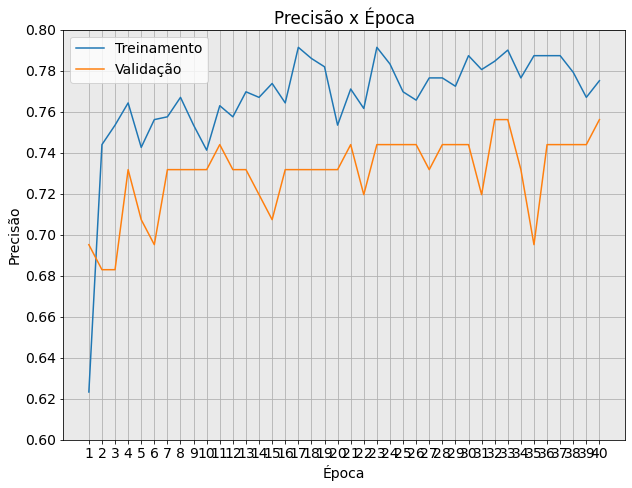

In [ ]:

hist_epoca = np.arange(1,epocas+1,1)
hist_train = pd.DataFrame({"Precisão":hist_train_acc,"Época":hist_epoca})
hist_val = pd.DataFrame({"Precisão":hist_val_acc,"Época":hist_epoca})
plt.rcParams["figure.figsize"] = [9.00, 7.00]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.titleweight"] = 10
plt.rcParams["font.style"] = 'normal'
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots()
ax = sns.lineplot(x = "Época", y = "Precisão",data= hist_train)
ax.set_facecolor('#EAEAEA')
ax1 = sns.lineplot(x = "Época", y = "Precisão",data= hist_val)
plt.legend(labels=['Treinamento', 'Validação'])
plt.yticks(np.arange(0.6,0.82,0.02))
x = np.arange(1,epocas+1,1)
#plt.xticks(x,hist_train['Época'])
plt.xticks(np.arange(1,epocas+1,1))
plt.title("Precisão x Época")
plt.grid()
#plt.suptitle("Precisão x Época",fontweight='bold')
plt.show()



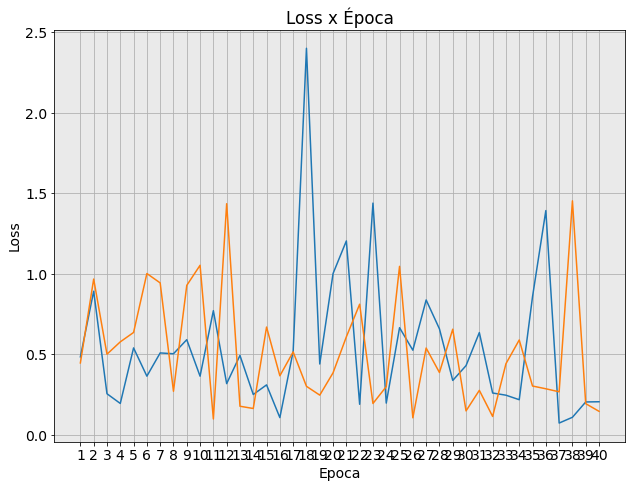

In [ ]:
hist_train_l = pd.DataFrame({"Loss":hist_train_loss,"Epoca":hist_epoca})
hist_val_l = pd.DataFrame({"Loss":hist_val_loss,"Epoca":hist_epoca})
plt.rcParams["figure.figsize"] = [9.00, 7.00]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.titleweight"] = 10
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots()
ax = sns.lineplot(x = "Epoca", y = "Loss",data= hist_train_l)
ax.set_facecolor('#EAEAEA')
ax1 = sns.lineplot(x = "Epoca", y = "Loss",data= hist_val_l)
plt.title("Loss x Época")
x = np.arange(1,11,1)
#plt.xticks(x,hist_epoca)
plt.xticks(np.arange(1,epocas+1,1))
#plt.yticks(np.arange(0.1,0.8,0.05))
plt.grid()
plt.show()



In [ ]:
n_test_ex = 0
test_hits = 0
test_hit = []

test_loss = 0

for batch_num, (features,labels) in enumerate(test_loader):
        
        with torch.no_grad():
            val_loss = 0

            model.eval()

            input_ids,input_masks = features [:,0,:],features[:,1,:]

            var_temp2 = model(input_ids,input_masks,labels = labels.long())

            loss, logits = var_temp2[0], var_temp2[1]

            test_loss += loss.item()

            softmax_pred = nn.functional.softmax(logits,dim=1)
            test_hits += acc_calc(softmax_pred,labels)
            test_hit.append(acc_calc(softmax_pred,labels).item())

            n_test_ex += features.shape[0]


In [ ]:
test_acc = torch.true_divide(test_hits,n_test_ex)
test_acc

tensor(1., device='cuda:0')

In [ ]:
test_hit,y_test

([1, 1, 1, 1, 1, 1, 1, 1], tensor([1., 1., 1., 1., 0., 0., 0., 0.]))

# Testes com sentenças avulsas
- É possivel testar o modelo diretamente em um resumo, basta que o texto passe pelo mesmo processo de limpeza, formatação e tokenização. A função abaixo automatiza esse processo.

In [ ]:
def prediction(text:str) -> str:
    text = prepare(text)
    batch = tokenizer(text,padding=True,truncation=True,max_length=150,return_tensors="pt").to(device)
    disciplinas = {0:"Eletrica",1:"Eletrônica"}
    with torch.no_grad():
        outputs = model(**batch)
        #print(outputs)
        predictions = F.softmax(outputs.logits,dim=1)
        #print(predictions)
        labels = torch.argmax(predictions,dim=1)
        #print(labels)
        return disciplinas.get(labels.item())  


In [ ]:
teste_1 = """O objetivo deste trabalho é propor um algoritmo para realizar a 
identificação de padrões na vocalização suína, visando determinar o nível do 
bem-estar do animal. Tal análise foi proposta uma vez que o bem-estar animal é 
um assunto cada vez mais abordado no mundo todo, principalmente quando os animais 
são criados para o abate. Dessa forma, a criação de um método em que haja o mínimo 
de contato com os animais se faz importante, evitando que tal contato altere o 
comportamento do animal e, conseqüentemente, o resultado da análise de seu bem-estar. 
Por essas características, foi proposto um método de análise dos sons emitidos pelos 
suínos com base na utilização de uma Rede Neural Artificial do tipo Radial Basis Function,
 como elementos de treinamento e operação um conjunto de características extraídas através
 ormada Discreta Wavelet de sinais sonoros pré-gravados. As características obtidas dos
sinais foram as energias das bandas críticas relativas à Escala Bark e a diferença 
entre as energias das bandas adjacentes, além dimensão fractal do sinal. Através
desse método foram analisados dois tipos de sinais sonoros: a vocalização de
leitões saudáveis e de leitões acometidos por uma doença chamada Artrite Traumática; 
 e a vocalização de suínos adultos em situações de conforto e desconforto. Os 
resultados demonstram que a análise proposta atingiu bons patamares de acerto na
determinação do bem-estar do animal"""
#eletronica 1

In [ ]:
prediction(teste_1)

'Eletrônica'

In [ ]:
teste_2 = """Produzindo inicialmente motores elétricos, a WEG ampliou 
suas atividades a partir da década de 80, com a produção de componentes 
eletroeletrônicos, produtos para automação industrial, transformadores de
 força e distribuição, tintas líquidas e em pó e vernizes eletroisolantes. 
 A empresa se consolidou não só como fabricante de motores, mas como fornecedora 
 de sistemas elétricos industriais completos."""
#eletrica 0

In [ ]:
prediction(teste_2)

'Eletrica'

In [ ]:
teste_3 = """Numa definição mais abrangente, podemos dizer que a eletrônica é o 
ramo da ciência que estuda o uso de circuitos formados por componentes elétricos
 e eletrônicos, com o objetivo principal de representar, armazenar, transmitir 
 ou processar informações além do controle de processos e servomecanismos. Sob 
 esta ótica, também se pode afirmar que os circuitos internos dos computadores 
 (que armazenam e processam informações), os sistemas de telecomunicações (que 
transmitem informações), os diversos tipos de sensores e transdutores (que representam
grandezas físicas - informações - sob forma de sinais elétricos) estão, todos, dentro 
da área de interesse da eletrônica."""
#eletronica1

In [ ]:
prediction(teste_3)

'Eletrônica'

In [ ]:
teste_4 = """projeto visa nova abordagem sistema vigilância móvel autônomo. pulseira 
biométrica coleta dados sobre batimento cardíaco usuário envia, via bluetooth, módulo
processamento, smartphone sistema operacional android, faz análise destes batimentos 
cardíacos define usuário passando alguma situação risco morte, extremo estresse. 
smartphone escreve, periodicamente, informações tempo imediato sobre usuário, localização
ica batimentos cardíacos, banco dados nuvem que, vez, contém informações pessoais usuário, 
tipo sanguíneo, telefone contato emergencial, alergias, outros. premissa dados nuvem
 acessíveis todo momento servidor externo servirem base socorro médico emergencial,
  seja, sistema visa prover auxílio imediato maneira proativa autônoma, modo preservar 
  vidas, sendo baixo custo alcançável grande parte população. realizados diversos testes 
  simulações demonstrando adequabilidade sistema proposto situações problema apresentadas"""
#eletronica 1

In [ ]:
prediction(teste_4)

'Eletrônica'

---

#Comparando com o modelo Tensorflow

O modelo tensorflow semelhante pode ser encontrado no link abaixo:

[Modelo TF-BERT](https://colab.research.google.com/drive/1sI6wb5BD7K6LBFmSs_30x9BjMUcPu94v?usp=sharing)

No comparativo entre sentenças avulsas os dois obtveram o memso resultado, errando a sentença 3.

In [ ]:
precisao = pd.DataFrame({ "Modelo":["Modelo PT-No_Scheduler","Modelo PT-Scheduler","Modelo TFBERT1","Modelo TFBERT2"],
    "Qtd. Disciplinas":[2,2,2,2],
    "Qtd. Resumos":[820,820,820,820],
    "Qtd. Res. Testes":[8,8,8,8],
    "Épocas":[10,10,20,50],
    "Loss":[0.2751,0.2718,0.4403,0.0908],
    "Accuracy":[0.7810,0.7702,0.8022,0.9603],
    "Val. Loss":[0.4700,0.5699,0.0728,0.5093],
    "Val. Accuracy":[0.7658,0.8200,0.9878,0.8875],
    "Precisão Testes":[100,100,87.5,75]
})

In [ ]:
precisao

,Modelo,Qtd. Disciplinas,Qtd. Resumos,Qtd. Res. Testes,Épocas,Loss,Accuracy,Val. Loss,Val. Accuracy,Precisão Testes
0,Modelo PT-No_Scheduler,2,820,8,10,0.2751,0.7810,0.4700,0.7658,100.0
1,Modelo PT-Scheduler,2,820,8,10,0.2718,0.7702,0.5699,0.8200,100.0
2,Modelo TFBERT1,2,820,8,20,0.4403,0.8022,0.0728,0.9878,87.5
3,Modelo TFBERT2,2,820,8,50,0.0908,0.9603,0.5093,0.8875,75.0


# Conclusão

O modelo Pytorch foi treinado com bem nenos épocas que os modelos Tensorflow, mas foram capazes de entregar precisão superior no dataset de testes, e igual para as sentenças avulsas.

O tempo de treinamento não foi comparado pois os modelos Tensorflow foram treinados em CPU, e os modelos Pytorch em GPU.

Este Modelo pode ser aperfeiçoado utilizando uma construção customizada dos layers finais, e com um dataset maior.

Foi observado que com o scheduler, a precisão de validação foi muito maior que sem utilizar.

Os resultados de Precisão, Loss, Precisão de Validação e Loss de Validação foram obtidos através da média de 5 treinamentos com cada modelo.

# Referências e Citação

### BERTimbal, por NeuralmindAI.

In [ ]:
"""
@inproceedings{souza2020bertimbau,
    author    = {Souza, F{\'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},
    title     = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese},
    booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)},
    year      = {2020}
}

@article{souza2019portuguese,
    title={Portuguese Named Entity Recognition using BERT-CRF},
    author={Souza, F{\'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},
    journal={arXiv preprint arXiv:1909.10649},
    url={http://arxiv.org/abs/1909.10649},
    year={2019}
}
"""

"\n@inproceedings{souza2020bertimbau,\n    author    = {Souza, F{'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},\n    title     = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese},\n    booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)},\n    year      = {2020}\n}\n\n@article{souza2019portuguese,\n    title={Portuguese Named Entity Recognition using BERT-CRF},\n    author={Souza, F{'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},\n    journal={arXiv preprint arXiv:1909.10649},\n    url={http://arxiv.org/abs/1909.10649},\n    year={2019}\n}\n"